# Setup
Local Spark Environment
- 4 Cores, 8 Threats (1.5Ghz Base Clock)
- 8 GB RAM (shared with OS)
- SSD 

In [1]:
import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col, regexp_replace, lower
import os


MAX_MEMORY = "6g"
spark = SparkSession.builder \
                    .appName('multi_class_text_classifiter')\
                    .master("local[*]") \
                    .config("spark.executor.memory", MAX_MEMORY) \
                    .config("spark.driver.memory", MAX_MEMORY) \
                    .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.3.1") \
                    .getOrCreate()

print("Apache Spark version: ", spark.version)
spark

Apache Spark version:  3.3.1


In [2]:
spark_df = spark.read.parquet('C://data/twitter-stream-parquet-small/')
dataSchema = spark_df.schema

print(f" Anzahl der Partitions: {spark_df.rdd.getNumPartitions()}")

spark_df.printSchema()

 Anzahl der Partitions: 4
root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |  

In [3]:
streaming = spark.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1).parquet('C://data/twitter-stream-parquet-small/')

Load Inference Pipeline

In [6]:
trained_pipeline = PipelineModel.load("../models/mllib_model_nb")

In [5]:
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, "(https?\://)\S+", "") # Remove links
  c = regexp_replace(c, "(\\n)|\n|\r|\t", "") # Remove CR, tab, and LR
  c = regexp_replace(c, "(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4})", "") # Remove dates
  c = regexp_replace(c, "@([A-Za-z0-9_]+)", "") # Remove usernames
  c = regexp_replace(c, "[0-9]", "") # Remove numbers
  c = regexp_replace(c, "\:|\/|\#|\.|\?|\!|\&|\"|\,", "") # Remove symbols
  return c

# Batch Processing

In [23]:
def batch_hate_inference(df, test):

    print(f'Iter: {test}')

    # Clean Text Columns
    df = df.withColumn("text", clean_text(col("text")))

    # Predict on Batch
    final_df = trained_pipeline.transform(df).select('text','prediction')

    # Handling for data (Save Hate Speech)
    hate = final_df.filter(final_df['prediction'] == 1.0)
    hate.write.mode('append').parquet('../data/parquet_output')
    times_hate = hate.count()
    print(f'Times hate detected: {times_hate}')

    not_hate = final_df.filter(final_df['prediction'] == 0.0)
    times_not_hate = not_hate.count()
    print(f'Times not hate detected: {times_not_hate}')


In [24]:
batchHateInference = streaming.writeStream.foreachBatch(batch_hate_inference).start() #

Iter: 0
Times hate detected: 17
Times not hate detected: 346
Iter: 1
Times hate detected: 29
Times not hate detected: 741
Iter: 2
Times hate detected: 32
Times not hate detected: 724
Iter: 3
Times hate detected: 27
Times not hate detected: 740


In [25]:
batchHateInference.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [15]:
batchHateInference.exception()

In [16]:
batchHateInference.stop()

The trigger can be optimized:
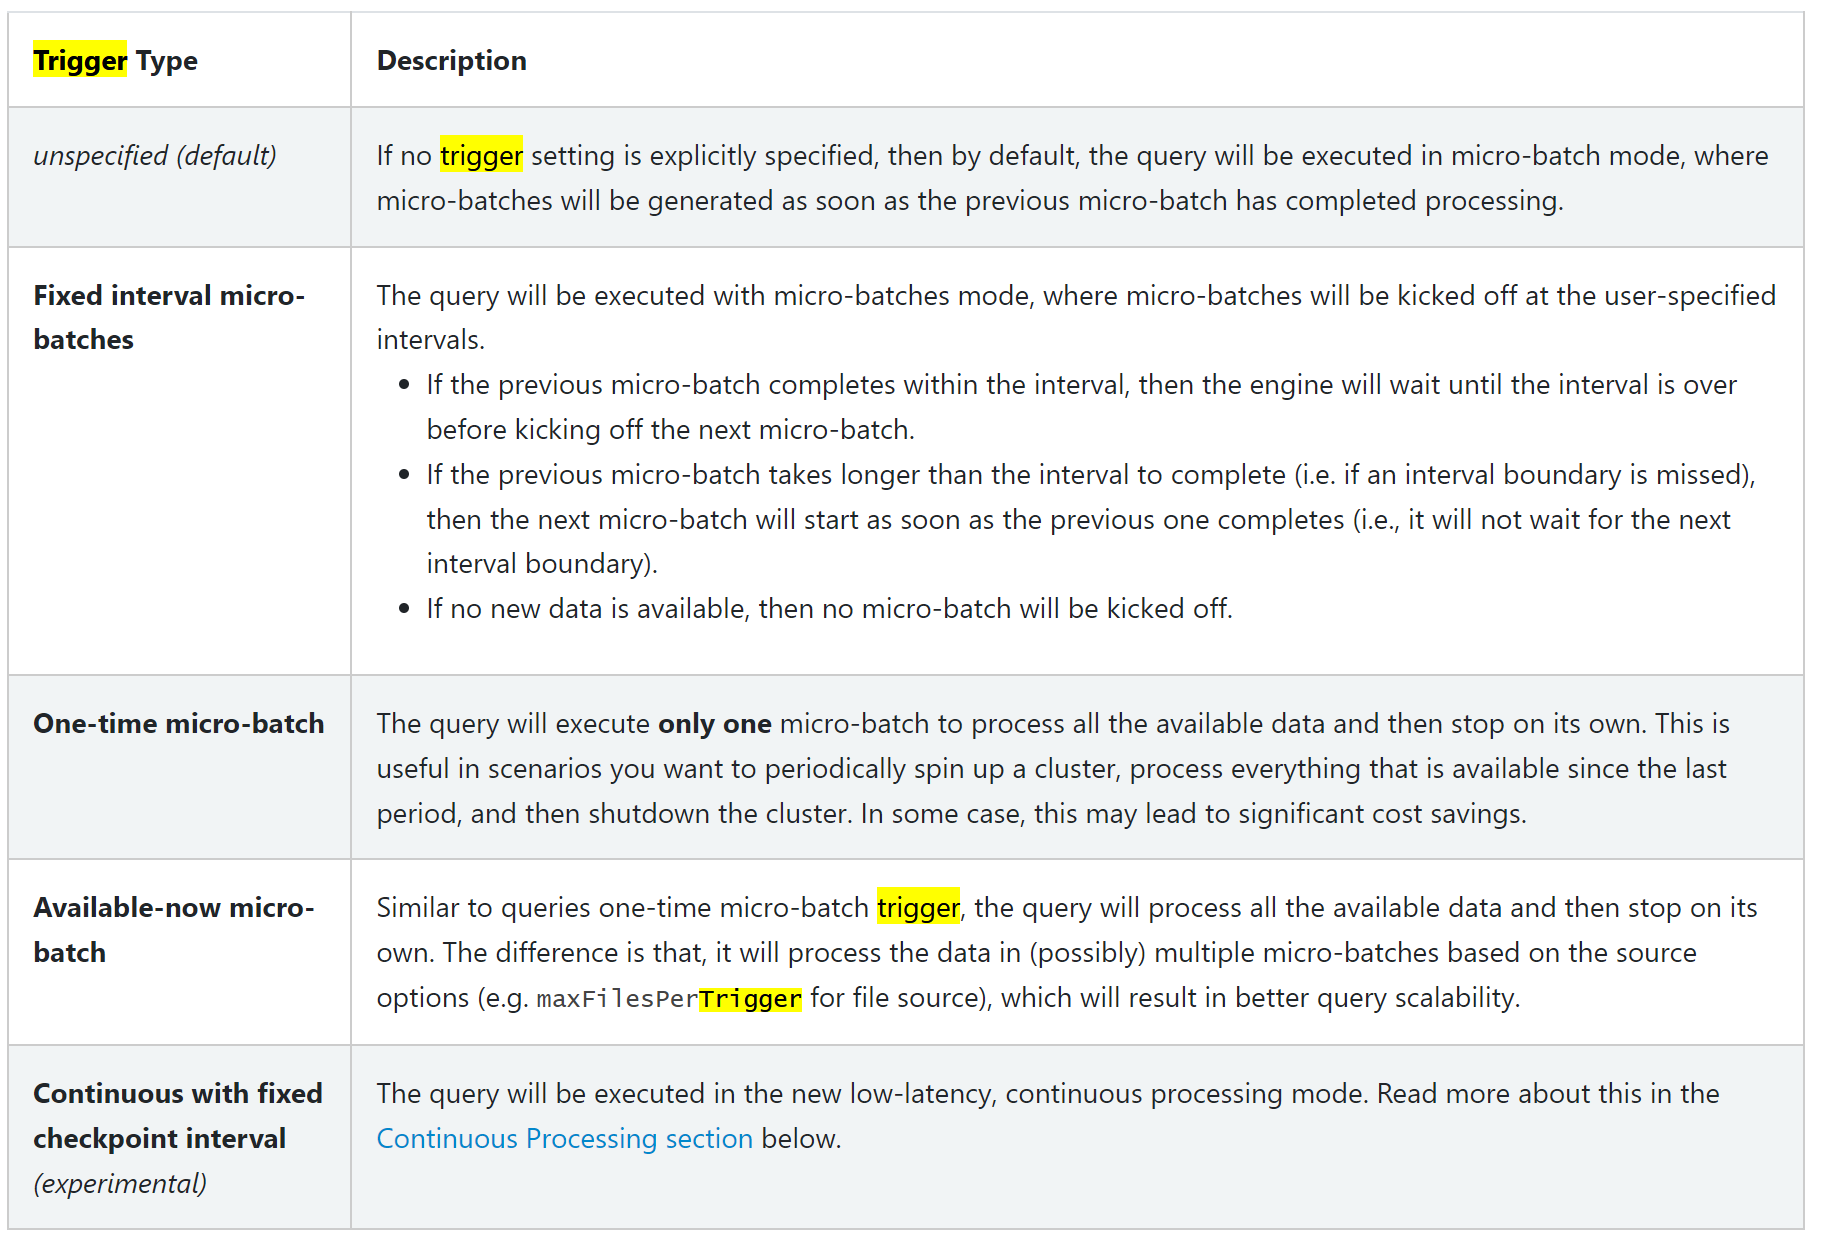

In [39]:
detected_hate_df = spark.read.parquet('../data/parquet_output')
hate_texts = detected_hate_df.select('text').toPandas()['text']
hate_texts

0                rt  ava addams gets banged from behind 
1      rt  putin vs the deep state - part one - denaz...
2      trump's latest hate rally a master class in cu...
3      rt  warm cum for the cold weather 🥵like and re...
4      —— very soft lots of cuddles kisses and beauti...
                             ...                        
100    rt  รวมคอมเม้นเนติเซนเกาหลี (ที่กลับมาเม้นกันใ...
101      your're like maddow most of this evidence ha...
102                                te amo te amo te amo 
103    rt  el nombre del campamento es “dignidad”lo q...
104    rt  eu tô muito triste que eu não vou poder as...
Name: text, Length: 105, dtype: object

# Live Processing

In [2]:
spark_df2 = spark.read.parquet('../data/parquet_data')
dataSchema = spark_df2.schema

print(f" Anzahl der Partitions: {spark_df2.rdd.getNumPartitions()}")

spark_df2.printSchema()

streaming2 = spark.readStream.schema(dataSchema).json('../data/parquet_data') #.withColumn("")

 Anzahl der Partitions: 8
root
 |-- index: long (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- majority_label: long (nullable = true)



In [75]:
def live_hate_inference(row):

    # text = row[['text']]
    
    print(row.dtype)
    #spark.write.mode('append').parquet('../data/hate_detected')

    # df = df.withColumn("text", clean_text(col("text")))

    # wordsDataFrame_transformed = prep_trained_pipeline.transform(df)
    # final_df = model_trained_pipeline.transform(wordsDataFrame_transformed).select('text','prediction')
    
    # times_hate = final_df.filter(final_df['prediction'] == 1.0).count()
    # print(f'Times hate detected: {times_hate}')
    # times_not_hate = final_df.filter(final_df['prediction'] == 0.0).count()
    # print(f'Times not hate detected: {times_not_hate}')

In [76]:
query = streaming2.writeStream.foreach(live_hate_inference).start()

In [77]:
query.status

{'message': 'Terminated with exception: Writing job aborted',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [78]:
query.exception()

pyspark.sql.utils.StreamingQueryException('Writing job aborted\n=== Streaming Query ===\nIdentifier: [id = b981fdf6-5ff5-4552-b376-25be424d9c2c, runId = 3450b711-2b2b-418b-a25c-aa4c1dfa3235]\nCurrent Committed Offsets: {}\nCurrent Available Offsets: {FileStreamSource[file:/c:/Users/Jonas Surface/OneDrive/Dokumente/GitHub/BigData_Live_Hate_Speech_Detection/data/parquet_data]: {"logOffset":0}}\n\nCurrent State: ACTIVE\nThread State: RUNNABLE\n\nLogical Plan:\nWriteToMicroBatchDataSource ForeachWriterTable(org.apache.spark.sql.execution.python.PythonForeachWriter@4ec6d41d,Right(org.apache.spark.sql.execution.streaming.sources.ForeachWriterTable$$$Lambda$2530/2122475036@3b547e47)), b981fdf6-5ff5-4552-b376-25be424d9c2c, Append\n+- StreamingExecutionRelation FileStreamSource[file:/c:/Users/Jonas Surface/OneDrive/Dokumente/GitHub/BigData_Live_Hate_Speech_Detection/data/parquet_data], [index#6L, tweet_text#7, majority_label#8L]\n',
                                          'org.apache.spark.sq

# Test other approaches

In [23]:
# liveHateInference = streaming2.writeStream.foreach(live_hate_inference).start()

In [5]:
# resultDf = streaming2.select("text")

# liveHateInference = resultDf.writeStream \
#   .outputMode("append") \
#   .format("csv") \
#   .option("path", "output/filesink_output") \
#   .option("header", True) \
#   .option("checkpointLocation", "checkpoint/filesink_checkpoint") \
#   .start()


In [8]:
liveHateInference.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [9]:
liveHateInference.exception()

In [38]:
liveHateInference.stop()

Rate Source Testing

In [ ]:
# Create a streaming DataFrame
df = spark.readStream \
    .format("rate") \
    .option("rowsPerSecond", 10) \
    .load()